# Reusable Embeddings

**Learning Objectives**
1. Learn how to use a pre-trained TF Hub text modules to generate sentence vectors
1. Learn how to incorporate a pre-trained TF-Hub module into a Keras model
1. Learn how to deploy and use a text model on CAIP



## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset.

First, we will load and pre-process the texts and labels so that they are suitable to be fed to sequential Keras models with first layer being TF-hub pre-trained modules. Thanks to this first layer, we won't need to tokenize and integerize the text before passing it to our models. The pre-trained layer will take care of that for us, and consume directly raw text. However, we will still have to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will build, train and compare simple DNN models starting with different pre-trained TF-Hub layers.

In [1]:
import os

from google.cloud import bigquery
import pandas as pd

In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Replace the variable values in the cell below:

In [3]:
PROJECT = "qwiklabs-gcp-04-8722038efd75"  # Replace with your PROJECT
BUCKET = PROJECT  # defaults to PROJECT
REGION = "us-west1"  # Replace with your REGION
SEED = 0

## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.stories?tab=details) contains all headlines from the sites inception in October 2006 until October 2015. 

Here is a sample of the dataset:

In [ ]:
%%bigquery --project $PROJECT

SELECT
    url, title, score
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    LENGTH(title) > 10
    AND score > 10
    AND LENGTH(url) > 0
LIMIT 10

Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

In [4]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source,
    COUNT(title) AS num_articles
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
GROUP BY
    source
ORDER BY num_articles DESC
  LIMIT 100

,source,num_articles
0,blogspot,41386
1,github,36525
2,techcrunch,30891
3,youtube,30848
4,nytimes,28787
...,...,...
95,f5,1254
96,gamasutra,1249
97,cnbc,1229
98,indiatimes,1223


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [5]:
regex = '.*://(.[^/]+)/'


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(regex)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(sub_query=sub_query)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [6]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

,title,source
0,this guy just found out how to bypass adblocker,github
1,show hn dodo command line task management f...,github
2,without coding test test automation for javas...,github
3,clojure s first code commit authored 8 years ...,github
4,hikaricp a solid high-performance jdbc connect...,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last colum to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [7]:
print("The full dataset contains {n} titles".format(n=len(title_dataset)))

The full dataset contains 96203 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [8]:
title_dataset.source.value_counts()

github        36525
techcrunch    30891
nytimes       28787
Name: source, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [9]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [10]:
FULL_DATASET_NAME = 'titles_full.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')

Now let's sample 1000 articles from the full dataset and make sure we have enough examples for each label in our sample dataset (see [here](https://cloud.google.com/natural-language/automl/docs/beginners-guide) for further details on how to prepare data for AutoML).

In [11]:
sample_title_dataset = title_dataset.sample(n=1000)
sample_title_dataset.source.value_counts()

github        374
techcrunch    320
nytimes       306
Name: source, dtype: int64

Let's write the sample datatset to disk.

In [12]:
SAMPLE_DATASET_NAME = 'titles_sample.csv'
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(
    SAMPLE_DATASET_PATH, header=False, index=False, encoding='utf-8')

In [13]:
import datetime
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow_hub import KerasLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2.1.0


In [14]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [15]:
MODEL_DIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

As in the previous labs, our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times):

In [16]:
ls ./data/

titles_full.csv  titles_sample.csv


In [17]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,pyreveng software reverse engineering toolkit ...,github
1,tencent launches a standalone wechat voip app,techcrunch
2,robocoin announces bitcoin bank,techcrunch
3,show hn html5 boilerplatter optimised for lo...,github
4,giveffect yc w15 has built a shopify-meets-s...,techcrunch


Let's look again at the number of examples per label to make sure we have a well-balanced dataset:

In [18]:
titles_df.source.value_counts()

github        36525
techcrunch    30891
nytimes       28787
Name: source, dtype: int64

## Preparing the labels

In this lab, we will use pre-trained [TF-Hub embeddings modules for english](https://tfhub.dev/s?q=tf2%20embeddings%20text%20english) for the first layer of our models. One immediate
advantage of doing so is that the TF-Hub embedding module will take care for us of processing the raw text. 
This also means that our model will be able to consume text directly instead of sequences of integers representing the words.

However, as before, we still need to preprocess the labels into one-hot-encoded vectors:

In [19]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [20]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [21]:
encode_labels(titles_df.source[:4])

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [22]:
N_TRAIN = int(len(titles_df) * 0.95)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per class.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.

In [23]:
sources_train.value_counts()

github        34698
techcrunch    29382
nytimes       27312
Name: source, dtype: int64

In [24]:
sources_valid.value_counts()

github        1827
techcrunch    1509
nytimes       1475
Name: source, dtype: int64

Now let's create the features and labels we will feed our models with:

In [25]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [26]:
X_train[:3]

array(['pyreveng software reverse engineering toolkit in python',
       'tencent launches a standalone wechat voip app',
       'robocoin announces bitcoin bank'], dtype=object)

In [27]:
Y_train[:3]

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## NNLM Model

We will first try a word embedding pre-trained using a [Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). TF-Hub has a 50-dimensional one called 
[nnlm-en-dim50-with-normalization](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1), which also
normalizes the vectors produced. 

### Lab Task 1a: Import NNLM TF Hub module into `KerasLayer`

Once loaded from its url, the TF-hub module can be used as a normal Keras layer in a sequential or functional model. Since we have enough data to fine-tune the parameters of the pre-trained embedding itself, we will set `trainable=True` in the `KerasLayer` that loads the pre-trained embedding:

In [29]:
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"
# TODO
nnlm_module = KerasLayer(
    NNLM, output_shape=[50], input_shape=[], dtype=tf.string, trainable=True)

Note that this TF-Hub embedding produces a single 50-dimensional vector when passed a sentence:

### Lab Task 1b: Use module to encode a sentence string

In [31]:
nnlm_module(tf.constant(["All work and no play makes Jack a dull boy"]))

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 2.11072475e-01, -1.69440061e-02,  7.46052638e-02,
         5.00822614e-04,  1.91563478e-04,  2.29420625e-02,
        -1.49906650e-01, -1.64991960e-01, -1.68451339e-01,
         1.80491552e-01,  7.36399321e-03,  1.06594816e-01,
         4.20251716e-04,  3.08306456e-01, -5.90783209e-02,
        -1.43224269e-01, -6.91283867e-02, -9.77035239e-02,
         7.10965171e-02, -2.11713657e-01, -8.97031426e-02,
         4.48904000e-02, -8.63847658e-02,  2.16586635e-01,
        -1.31788000e-01, -1.24031030e-01, -3.65267903e-01,
         2.94511653e-02,  2.62986541e-01, -2.04840571e-01,
        -1.21046089e-01,  3.07913795e-02,  8.33896250e-02,
        -4.82376069e-02, -3.13785337e-02,  1.10020608e-01,
         6.19615838e-02,  1.35093585e-01,  1.49408594e-01,
        -4.49633598e-01,  1.04217164e-01, -5.89081757e-02,
         8.56496021e-02,  1.17159173e-01, -1.62678614e-01,
         5.75939380e-03, -9.33899283e-02,  3.11726406e-02,
       

## Swivel Model

Then we will try a word embedding obtained using [Swivel](https://arxiv.org/abs/1602.02215), an algorithm that essentially factorizes word co-occurrence matrices to create the words embeddings. 
TF-Hub hosts the pretrained [gnews-swivel-20dim-with-oov](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) 20-dimensional Swivel module.

### Lab Task 1c: Import Swivel TF Hub module into `KerasLayer`

In [32]:
SWIVEL = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
# TODO
swivel_module = KerasLayer(
    SWIVEL, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True)

Similarly as the previous pre-trained embedding, it outputs a single vector when passed a sentence:

### Lab Task 1d: Use module to encode a sentence string

In [33]:
swivel_module(tf.constant(["All work and no play makes Jack a dull boy"]))

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 1.020172  , -1.3913286 ,  0.51212394, -0.70574886, -1.1756471 ,
        -0.12778535, -0.68083495,  0.76214236,  1.4087591 , -0.13887222,
        -1.2303286 ,  0.69686097,  0.39239246, -0.06447788, -1.8282816 ,
         0.34047654,  1.0226002 ,  0.09324101, -0.89324784, -0.5104647 ]],
      dtype=float32)>

## Building the models

Let's write a function that 

* takes as input an instance of a `KerasLayer` (i.e. the `swivel_module` or the `nnlm_module` we constructed above) as well as the name of the model (say `swivel` or `nnlm`)
* returns a compiled Keras sequential model starting with this pre-trained TF-hub layer, adding one or more dense relu layers to it, and ending with a softmax layer giving the probability of each of the classes:

### Lab Task 2: Incorporate a pre-trained TF Hub module as first layer of Keras Sequential Model

In [34]:
def build_model(hub_module, name):
    model = Sequential([
        # TODO
        hub_module,
        Dense(16, activation='relu'),
        Dense(N_CLASSES, activation='softmax')
    ], name=name)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's also wrap the training code into a `train_and_evaluate` function that 
* takes as input the training and validation data, as well as the compiled model itself, and the `batch_size`
* trains the compiled model for 100 epochs at most, and does early-stopping when the validation loss is no longer decreasing
* returns an `history` object, which will help us to plot the learning curves

In [35]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    X_train, Y_train = train_data

    tf.random.set_seed(33)

    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)

    history = model.fit(
        X_train, Y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=[EarlyStopping(), TensorBoard(model_dir)],
    )
    return history

## Training NNLM

In [36]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

In [37]:
nnlm_model = build_model(nnlm_module, 'nnlm')
nnlm_history = train_and_evaluate(data, val_data, nnlm_model)

Train on 91392 samples, validate on 4811 samples
Epoch 1/100
91392/91392 [==============================] - 10s 113us/sample - loss: 1.0739 - accuracy: 0.4300 - val_loss: 1.0176 - val_accuracy: 0.5689
Epoch 2/100
91392/91392 [==============================] - 9s 93us/sample - loss: 0.9628 - accuracy: 0.6422 - val_loss: 0.8981 - val_accuracy: 0.6824
Epoch 3/100
91392/91392 [==============================] - 9s 95us/sample - loss: 0.8192 - accuracy: 0.7335 - val_loss: 0.7432 - val_accuracy: 0.7578
Epoch 4/100
91392/91392 [==============================] - 9s 95us/sample - loss: 0.6570 - accuracy: 0.7904 - val_loss: 0.5980 - val_accuracy: 0.7990
Epoch 5/100
91392/91392 [==============================] - 9s 93us/sample - loss: 0.5246 - accuracy: 0.8212 - val_loss: 0.5011 - val_accuracy: 0.8165
Epoch 6/100
91392/91392 [==============================] - 9s 98us/sample - loss: 0.4369 - accuracy: 0.8435 - val_loss: 0.4450 - val_accuracy: 0.8300
Epoch 7/100
91392/91392 [========================

<AxesSubplot:>

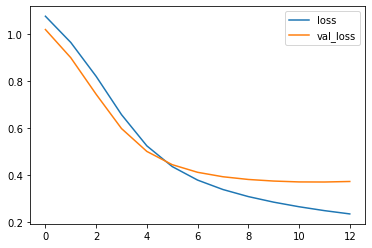

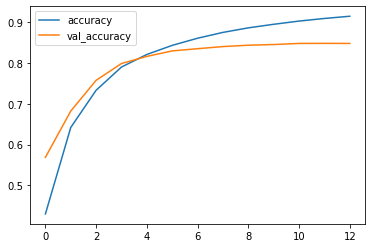

In [38]:
history = nnlm_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

## Training Swivel

In [39]:
swivel_model = build_model(swivel_module, name='swivel')

In [40]:
swivel_history = train_and_evaluate(data, val_data, swivel_model)

Train on 91392 samples, validate on 4811 samples
Epoch 1/100
91392/91392 [==============================] - 1s 12us/sample - loss: 1.1824 - accuracy: 0.3454 - val_loss: 1.1014 - val_accuracy: 0.4122
Epoch 2/100
91392/91392 [==============================] - 1s 6us/sample - loss: 1.0610 - accuracy: 0.4460 - val_loss: 1.0145 - val_accuracy: 0.5053
Epoch 3/100
91392/91392 [==============================] - 1s 6us/sample - loss: 0.9861 - accuracy: 0.5228 - val_loss: 0.9542 - val_accuracy: 0.5529
Epoch 4/100
91392/91392 [==============================] - 1s 6us/sample - loss: 0.9283 - accuracy: 0.5719 - val_loss: 0.9033 - val_accuracy: 0.5897
Epoch 5/100
91392/91392 [==============================] - 1s 7us/sample - loss: 0.8757 - accuracy: 0.6089 - val_loss: 0.8542 - val_accuracy: 0.6205
Epoch 6/100
91392/91392 [==============================] - 1s 7us/sample - loss: 0.8233 - accuracy: 0.6421 - val_loss: 0.8051 - val_accuracy: 0.6489
Epoch 7/100
91392/91392 [==============================]

<AxesSubplot:>

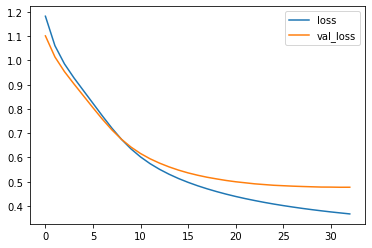

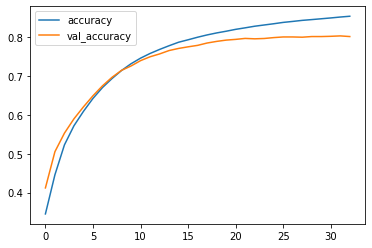

In [41]:
history = swivel_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

Swivel trains faster but achieves a lower validation accuracy, and requires more epochs to train on.

## Deploying the model

The first step is to serialize one of our trained Keras model as a SavedModel:

In [42]:
OUTPUT_DIR = "./savedmodels"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)

EXPORT_PATH = os.path.join(OUTPUT_DIR, 'swivel')
os.environ['EXPORT_PATH'] = EXPORT_PATH

shutil.rmtree(EXPORT_PATH, ignore_errors=True)

tf.saved_model.save(swivel_model, EXPORT_PATH)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./savedmodels/swivel/assets


INFO:tensorflow:Assets written to: ./savedmodels/swivel/assets


Then we can deploy the model using the gcloud CLI as before:

### Lab Task 3a: Complete the following script to deploy the swivel model 

In [47]:
%%bash

# TODO 5

PROJECT="qwiklabs-gcp-04-8722038efd75"
BUCKET=${PROJECT}
REGION=us-central1
MODEL_NAME=swivel_model_Jose
VERSION_NAME=swivel
EXPORT_PATH=$EXPORT_PATH

if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "$MODEL_NAME already exists"
else
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --regions=$REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    echo yes | gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 2
fi

echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud beta ai-platform versions create \
  --model=$MODEL_NAME $VERSION_NAME \
  --framework=tensorflow \
  --python-version=3.7 \
  --runtime-version=2.1 \
  --origin=$EXPORT_PATH \
  --staging-bucket=gs://$BUCKET \
  --machine-type n1-standard-4

Creating swivel_model_Jose
Creating swivel_model_Jose:swivel


Using endpoint [https://ml.googleapis.com/]
Using endpoint [https://ml.googleapis.com/]
Created ml engine model [projects/qwiklabs-gcp-04-8722038efd75/models/swivel_model_Jose].
Using endpoint [https://ml.googleapis.com/]
Using endpoint [https://ml.googleapis.com/]
Creating version (this might take a few minutes)......
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Before we try our deployed model, let's inspect its signature to know what to send to the deployed API:

In [48]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir {EXPORT_PATH}
!find {EXPORT_PATH}

2020-12-18 14:57:57.640546: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2020-12-18 14:57:57.640714: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2020-12-18 14:57:57.640739: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_

Let's go ahead and hit our model:

### Lab Task 3b: Create the JSON object to send a title to the API  you just deployed
(**Hint:** Look at the 'saved_model_cli show' command output above.)

In [49]:
%%writefile input.json
{"keras_layer_1_input": "hello"}

Writing input.json


In [51]:
!gcloud ai-platform predict \
  --model swivel_model_Jose \
  --json-instances input.json \
  --version swivel

Using endpoint [https://ml.googleapis.com/]
[[0.809389412, 0.06547001, 0.125140592]]


To take a quick anonymous survey, run:
  $ gcloud survey



## Bonus

Try to beat the best model by modifying the model architecture, changing the TF-Hub embedding, and tweaking the training parameters.

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License